In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import CRS
import contextily as ctx

In [2]:
place_name = "Kamppi, Helsinki, Finland"

# Retrieve the network
graph = ox.graph_from_place(place_name, network_type='bike')

C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


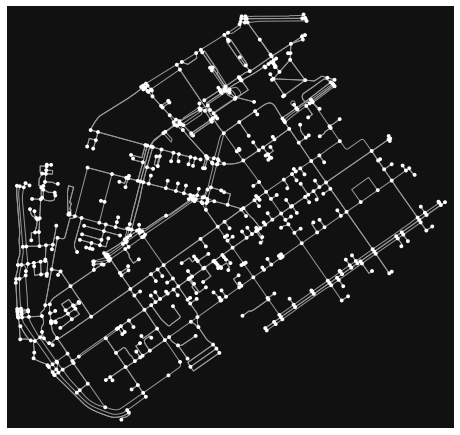

In [3]:
# plot the graph:
fig, ax = ox.plot_graph(graph)

In [4]:
# Get the area of interest polygon
place_polygon = ox.geocode_to_gdf(place_name)

# Re-project the polygon to a local projected CRS 
place_polygon = place_polygon.to_crs(epsg=3067)

# Buffer a bit
place_polygon["geometry"] = place_polygon.buffer(200)

# Re-project the polygon back to WGS84, as required by osmnx
place_polygon = place_polygon.to_crs(epsg=4326)

# Retrieve the network
graph = ox.graph_from_polygon(place_polygon["geometry"].values[0], network_type='bike')

C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


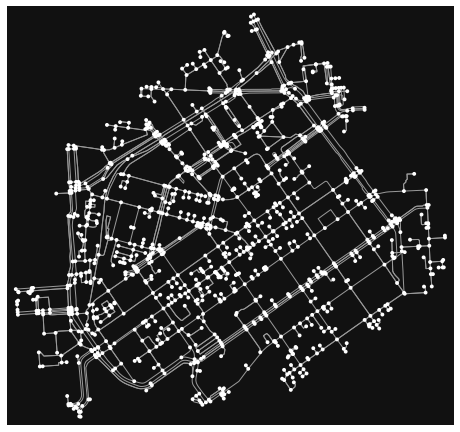

In [5]:
fig, ax = ox.plot_graph(graph)

In [6]:
# retrieve edges from graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [7]:
edges.columns

Index(['osmid', 'oneway', 'lanes', 'name', 'highway', 'maxspeed', 'length',
       'geometry', 'junction', 'access', 'bridge', 'tunnel', 'service'],
      dtype='object')

In [8]:
edges.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
edges.head()

osmid  oneway lanes             name  \
u        v          key                                                       
25216594 1372425721 0               23717777    True     2    Porkkalankatu   
         1372425714 0               23856784    True     2   Mechelininkatu   
25238865 146447626  0    [59355210, 4229487]   False     2        Santakatu   
         57661989   0                7842621   False   NaN  Sinikaislankuja   
         314767800  0              231643806   False   NaN              NaN   

                             highway maxspeed  length  \
u        v          key                                 
25216594 1372425721 0        primary       40  10.404   
         1372425714 0        primary       40  40.885   
25238865 146447626  0    residential       30  44.303   
         57661989   0    residential       30  76.704   
         314767800  0       cycleway      NaN  60.066   

                                                                  geometry  \
u        v          key                                                      
25216594 1372425721 0    LINESTRING (24.92106 60.16479, 24.92087 60.16479)   
         1372425714 0    LINESTRING (24.92106 60.16479, 24.92095 60.164...   
25238865 146447626  0    LINESTRING (24.91994 60.16279, 24.91932 60.162...   
         57661989   0    LINESTRING (24.91994 60.16279, 24.91995 60.162...   
         314767800  0    LINESTRING (24.91994 60.16279, 24.92014 60.162...   

                        junction access bridge tunnel service  
u        v          key                                        
25216594 1372425721 0        NaN    NaN    NaN    NaN     NaN  
         1372425714 0        NaN    NaN    NaN    NaN     NaN  
25238865 146447626  0        NaN    NaN    NaN    NaN     NaN  
         57661989   0        NaN    NaN    NaN    NaN     NaN  
         314767800  0        NaN    NaN    NaN    NaN     NaN

In [10]:
# lets look at the kind of features present in the highway column
edges['highway'].value_counts()

service                      890
cycleway                     473
residential                  467
tertiary                     217
primary                      167
pedestrian                   162
secondary                    121
unclassified                  42
living_street                 16
[cycleway, residential]        6
[living_street, service]       6
[pedestrian, residential]      4
[cycleway, pedestrian]         4
tertiary_link                  2
[pedestrian, service]          2
primary_link                   1
[unclassified, service]        1
Name: highway, dtype: int64

In [11]:
# reproject data into metric system before doing shortest path analysis
graph_proj = ox.project_graph(graph)

In [12]:
# retrieve edges and nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [13]:
edges_proj.head()

osmid  oneway  \
u          v          key                                                    
25216594   1372425721 0                                   23717777    True   
           1372425714 0                                   23856784    True   
1372425721 25290781   0                                   29191566   False   
           60070671   0          [930820929, 930820930, 654270815]   False   
1372425714 25238874   0    [78537378, 8169098, 29081876, 78537375]    True   

                            lanes            name   highway maxspeed   length  \
u          v          key                                                       
25216594   1372425721 0         2   Porkkalankatu   primary       40   10.404   
           1372425714 0         2  Mechelininkatu   primary       40   40.885   
1372425721 25290781   0       NaN             NaN  cycleway      NaN  228.587   
           60070671   0       NaN             NaN  cycleway      NaN   41.006   
1372425714 25238874   0    [2, 3]  Mechelininkatu   primary       40   85.540   

                                                                    geometry  \
u          v          key                                                      
25216594   1372425721 0    LINESTRING (384631.322 6671580.071, 384620.884...   
           1372425714 0    LINESTRING (384631.322 6671580.071, 384624.750...   
1372425721 25290781   0    LINESTRING (384620.884 6671579.965, 384621.184...   
           60070671   0    LINESTRING (384620.884 6671579.965, 384620.720...   
1372425714 25238874   0    LINESTRING (384624.179 6671539.986, 384623.768...   

                          junction bridge tunnel access service  
u          v          key                                        
25216594   1372425721 0        NaN    NaN    NaN    NaN     NaN  
           1372425714 0        NaN    NaN    NaN    NaN     NaN  
1372425721 25290781   0        NaN    NaN    NaN    NaN     NaN  
           60070671   0        NaN    NaN    NaN    NaN     NaN  
1372425714 25238874   0        NaN    NaN    NaN    NaN     NaN

In [14]:
print(f'Cordinate Reference system: {edges_proj.crs}')

Cordinate Reference system: +proj=utm +zone=35 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [15]:
# check the epsg code for this projection
CRS(edges_proj.crs).to_epsg()

32635

### network analysis

In [16]:
# get basic stats of the street netowrk
stats = ox.basic_stats(graph_proj, circuity_dist='euclidean')
stats

C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\osmnx\stats.py:370: UserWarning: The `circuity_dist` argument has been deprecated and will be removed in a future release.
  warnings.warn(msg)


{'n': 1206,
 'm': 2581,
 'k_avg': 4.2802653399668324,
 'edge_length_total': 90966.20699999998,
 'edge_length_avg': 35.24455908562572,
 'streets_per_node_avg': 2.6965174129353233,
 'streets_per_node_counts': {0: 0, 1: 324, 2: 17, 3: 584, 4: 263, 5: 18},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.26865671641791045,
  2: 0.014096185737976783,
  3: 0.4842454394693201,
  4: 0.21807628524046435,
  5: 0.014925373134328358},
 'intersection_count': 882,
 'street_length_total': 57144.00699999986,
 'street_segment_count': 1585,
 'street_length_avg': 36.053001261829564,
 'circuity_avg': 1.0412534589278488,
 'self_loop_proportion': 0.0018927444794952682}

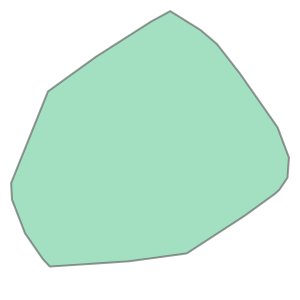

In [17]:
# to be able to do complex analysis of the areas network, we need the coverage area of the area
# this is done by getting the convex hull of the area
convex_hull = edges_proj.unary_union.convex_hull

convex_hull

In [18]:
# use the convex_hull to calculate extended statistics of the area
area = convex_hull.area

# calc stats with density information
stats = ox.basic_stats(graph_proj, area=area)
exstats = ox.extended_stats(graph_proj, ecc=True, cc=True)

for k, v in exstats.items():
    stats[k] = v
    
pd.Series(stats)

C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\osmnx\stats.py:458: UserWarning: The extended_stats function has been deprecated and will be removed in a future release. Use NetworkX directly for extended topological measures.
  warnings.warn(msg)


n                                                                                   1206
m                                                                                   2581
k_avg                                                                           4.280265
edge_length_total                                                              90966.207
edge_length_avg                                                                35.244559
streets_per_node_avg                                                            2.696517
streets_per_node_counts                     {0: 0, 1: 324, 2: 17, 3: 584, 4: 263, 5: 18}
streets_per_node_proportions           {0: 0.0, 1: 0.26865671641791045, 2: 0.01409618...
intersection_count                                                                   882
street_length_total                                                            57144.007
street_segment_count                                                                1585
street_length_avg    

### shortest path analysis

In [19]:
placename = "Maria 01, Helsinki"
geocoded_place = ox.geocode_to_gdf(placename)
geocoded_place

C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((24.92122 60.16644, 24.92126 60.16625...",60.167525,60.16624,24.92317,24.921221,106870241,way,23856740,60.166884,24.921661,"Maria 01, 16, Lapinlahdenkatu, Etu-Töölö, Hels...",building,yes,0.58084


<AxesSubplot:>

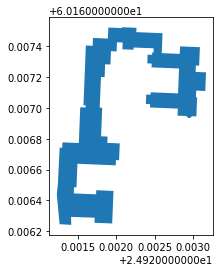

In [20]:
geocoded_place.plot()

In [21]:
geocoded_place.to_crs(CRS(edges.crs), inplace=True)

In [22]:
geocoded_place.crs == edges.crs

True

In [74]:

def get_point(place_name):
    """
    get_point geocodes the name of a place and returns
    the center point of the geocoded place
    """
    geo = ox.geocode_to_gdf(place_name)
    geo = geo.to_crs(CRS(edges_proj.crs))
    assert geo.crs == edges_proj.crs, "data must be in the same crs"
    return geo['geometry'].centroid.values[0]

In [75]:
origin = get_point("Maria 01, Helsinki")
destination = get_point("ruttopuisto, helsinki")

C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [76]:
print(origin, destination)

POINT (384692.1787195493 6671817.486579246) POINT (385673.4277923344 6671690.223032337)


In [87]:
def nearest_node_to_points(*points):
    """get the nearest nodes to points returning the resulting nodes as
    a geopandas geodaframe
    
    Parameters
    ------------
    points: shapely.Points
    """
    # nearest point function of osmnx takes points in tuple (lat, long) format
    coords = [(point.y, point.x) for point in points]
    # get node ids of the nearest nodes to points
    node_ids = [ox.get_nearest_node(graph_proj, point, method='euclidean') for point in coords]
    # get the nodes that the ids refer to
    nodes = [nodes_proj.loc[nid] for nid in node_ids]
    return gpd.GeoDataFrame(nodes, geometry='geometry', crs=nodes_proj.crs), node_ids

In [88]:
nodes, node_ids = nearest_node_to_points(origin, destination)

C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [89]:
def get_shortest_route(*node_ids):
    # get osmid of the data in nodes
    assert len(ids) == 2, 'shortest route is done between two points'
    return nx.shortest_path(G=graph_proj, source=node_ids[0], target=node_ids[1], weight='length')
    
def plot_route(route):
    ox.plot_graph_route(graph_proj, route)

In [90]:
route = get_shortest_route(*node_ids)

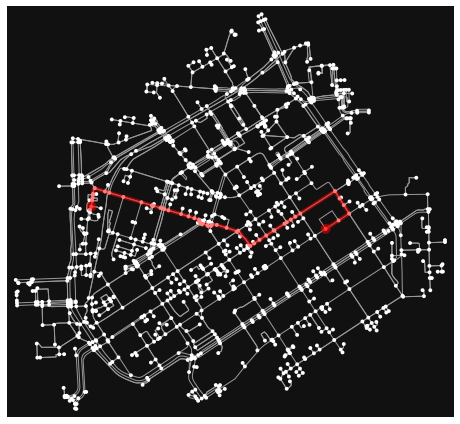

In [92]:
plot_route(route)

In [93]:
route_nodes = nodes_proj.loc[route]

In [100]:
route_nodes.head()

,y,x,street_count,lon,lat,highway,ref,geometry
osmid,,,,,,,,
319719983,6.671816e+06,384706.296089,3,24.922273,60.166932,NaN,NaN,POINT (384706.296 6671815.989)
1382316822,6.671839e+06,384709.579017,4,24.922319,60.167142,NaN,NaN,POINT (384709.579 6671839.311)
1382316829,6.671850e+06,384711.044607,3,24.922339,60.167236,NaN,NaN,POINT (384711.045 6671849.707)
1382316852,6.671861e+06,384712.504583,3,24.922359,60.167338,NaN,NaN,POINT (384712.505 6671860.984)
5464887863,6.671865e+06,384713.220293,3,24.922370,60.167377,NaN,NaN,POINT (384713.220 6671865.374)


In [95]:
from shapely.geometry import LineString, Point

In [103]:
def route_to_gdf(nodes):
    """convert node of routes to a geodataframe"""
    line = LineString(list(nodes.geometry.values))
    gdf = gpd.GeoDataFrame([[line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])
    gdf.loc[0, 'osmids'] = str(list(nodes.index.values))
    gdf['length_m'] = gdf.length
    return gdf

In [104]:
route_geom = route_to_gdf(route_nodes)

In [105]:
route_geom.head()

,geometry,osmids,length_m
0,"LINESTRING (384706.296 6671815.989, 384709.579...","[319719983, 1382316822, 1382316829, 1382316852...",1342.967643


In [106]:
def geometry_from_place(name, tags, crs=None):
    geom = ox.geometries_from_place(name, tags)
    return geom.to_crs(crs) if crs is not None else geom

In [107]:
buildings = geometry_from_place(place_name, {'buildings': True}, crs=edges_proj.crs)

C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [111]:
def plot_and_save_graph(filename):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # plot edges and nodes
    edges_proj.plot(ax=ax, linewidth=0.75, color='gray')
    nodes_proj.plot(ax=ax, markersize=2, color='gray')
    
    # plot buildings
    buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)
    
    # add route
    route_geom.plot(ax=ax, color='red', linewidth=2, linestyle='--')
    
    # plot origin and destination point
    nodes.plot(ax=ax, markersize=30, color='red')
    
    # add basemap
    ctx.add_basemap(ax, crs=buildings.crs, source=ctx.providers.CartoDB.Positron)
    
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


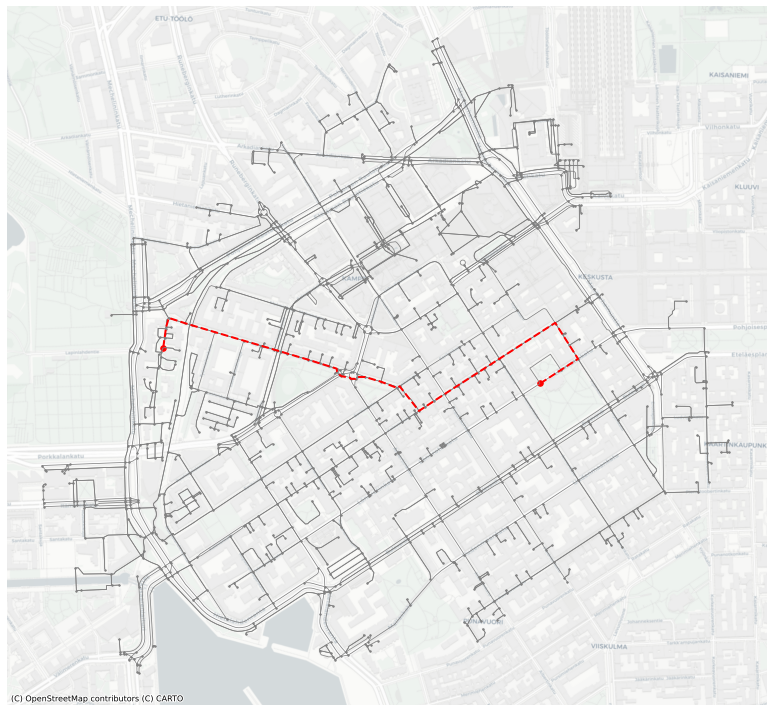

In [112]:
plot_and_save_graph('shortest_distance_map.png')

In [113]:
# Check if columns contain any list values
(edges_proj.applymap(type) == list).any()

osmid        True
oneway      False
lanes        True
name         True
highway      True
maxspeed     True
length      False
geometry    False
junction    False
bridge      False
tunnel      False
access      False
service      True
dtype: bool

In [114]:
# Columns with invalid values
invalid_cols = ['lanes', 'maxspeed', 'name', 'oneway', 'osmid', "highway", "service"]

#  convert selected columns to string format
edges_proj[invalid_cols] = edges_proj[invalid_cols].astype(str)

In [117]:
buildings.head()

,geometry


In [116]:
import os

# Parse the place name for the output file names (replace spaces with underscores and remove commas)
place_name_out = place_name.replace(' ', '_').replace(',','')

# Output directory
out_dir = "data"

# Create output fp for a geopackage
out_fp = os.path.join(out_dir, f"OSM_{place_name_out}.gpkg")

# Save files
edges_proj.to_file(out_fp, layer="streets", driver="GPKG")
route_geom.to_file(out_fp, layer="route", driver="GPKG")
nodes_proj.to_file(out_fp, layer="nodes", driver="GPKG")
nodes.to_file(out_fp, layer="route_OD", driver="GPKG")
buildings[['geometry', 'name', 'addr:street']].to_file(out_fp, layer="buildings", driver="GPKG")

C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


KeyError: "['name', 'addr:street'] not in index"